# Layout automation with python

### Thomas Ferreira de Lima

**NEC Labs America, Princeton, USA**

**June 6, 2022**

https://github.com/thomaslima/2022-SiEPIC-workshop-zeropdk

Email: thomas@nec-labs.com

# Outline

- Motivation for procedural layout
- Basic definitions
- Tool requirements
    - KLayout
    - Python/Docker
- An overview of Zeropdk
- Demo preparation
- Using SiEPIC with Zeropdk
    - Demo 1: Using SiEPIC cell library
- Hierarchical layout
    - Demo 2: MZI PCell
- Advanced layout techniques:
    + Geometry unit testing (lytest)
    + Visual debugging (lyipc)
    + Version control and collaboration
    + Outlook (help needed with DRC, SiEPIC and docs)

# Motivation for procedural layout

- [GDSII](https://www.artwork.com/gdsii/gdsii/) is the industry standard file format for IC layout.
- It organizes geometry in polygons, cells, and cell references.
- However, it is quasi-binary: understood by machines, useless to humans.
- There is no support for parameters, design intent, comments, connectivity, physical data.
- Poor representation of curves

## GDS has problems with curves

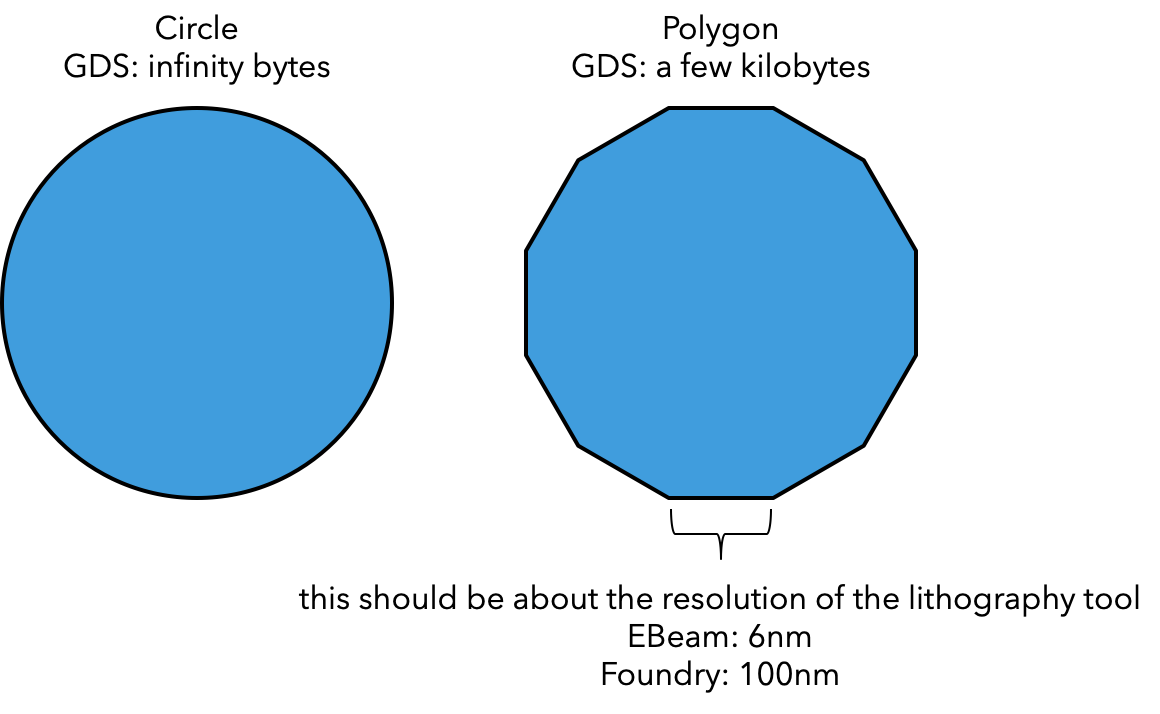

## GDS does not capture logical relation
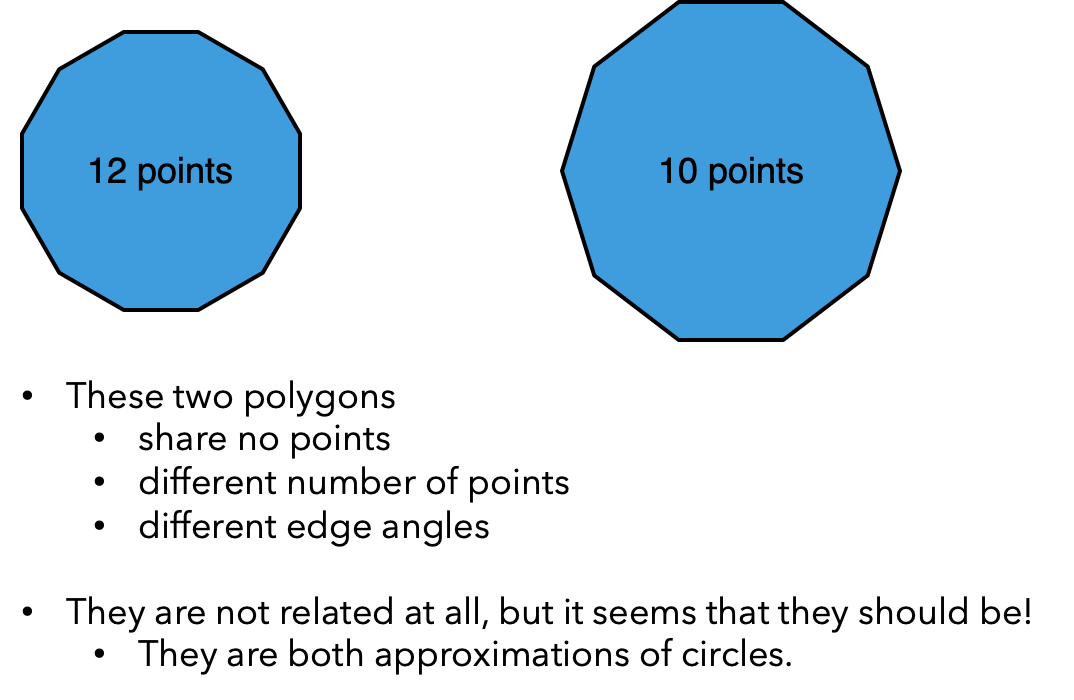

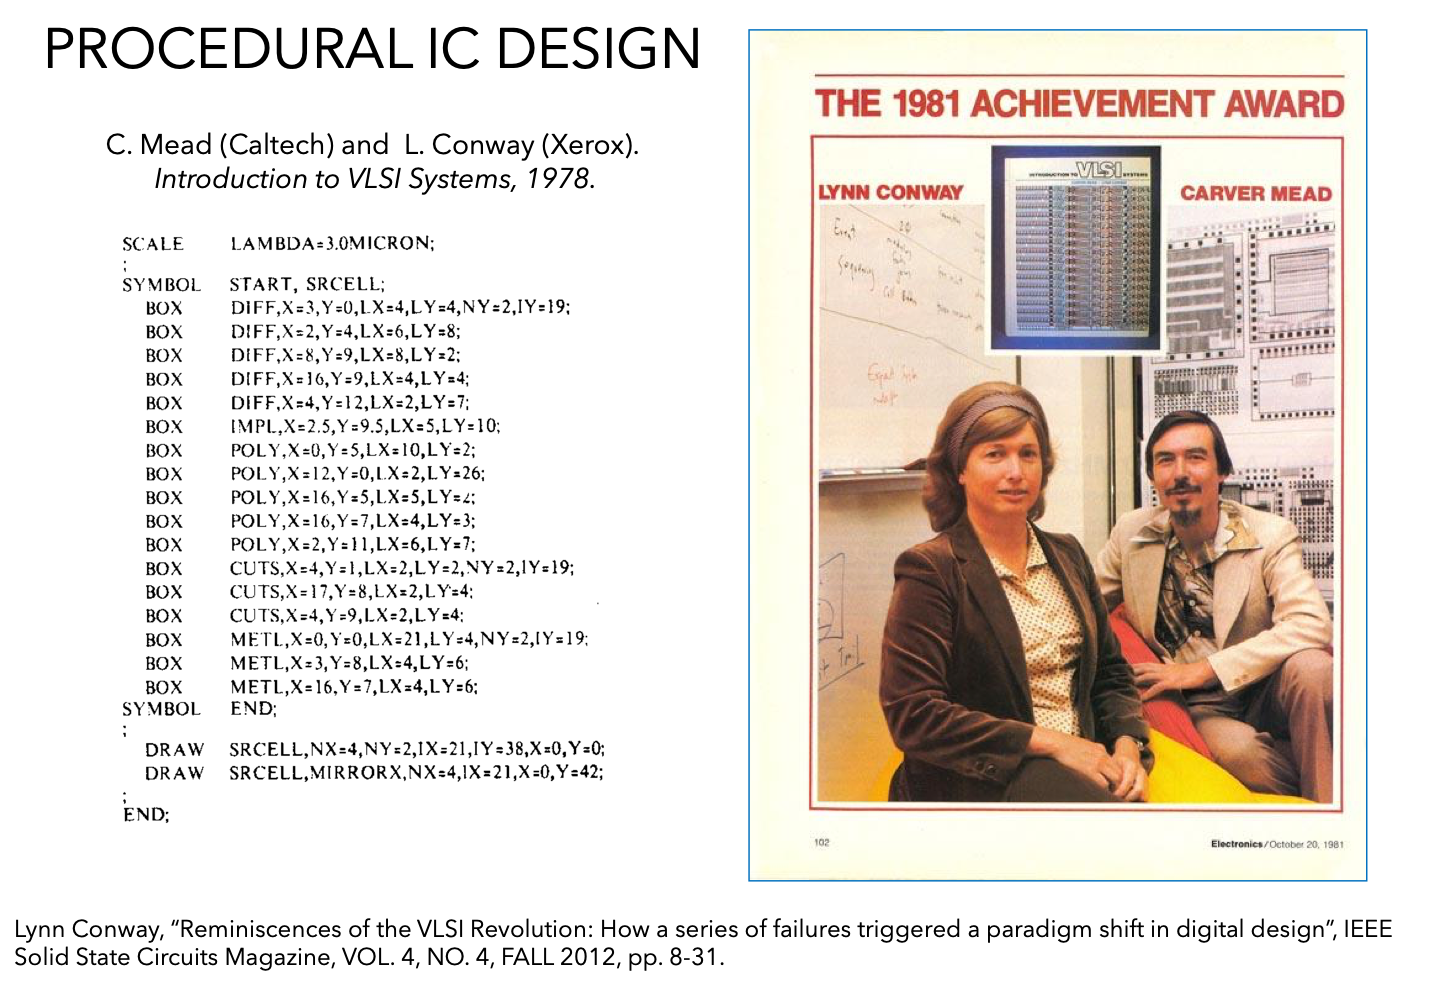

# Procedural vs. Computer-aided

- Computer-aided layout
    + Interactive: designer sees what’s happening at all times
    + Intuitive
    + No software bugs
    + Macros: some benefits of procedural

- Procedural layout
    + Completely repeatable
    + Easy to apply global changes
    + Easy to version a chip, not just a library
    + Full record of design intent


# IC design “by hand”, aided **A LOT** by computer

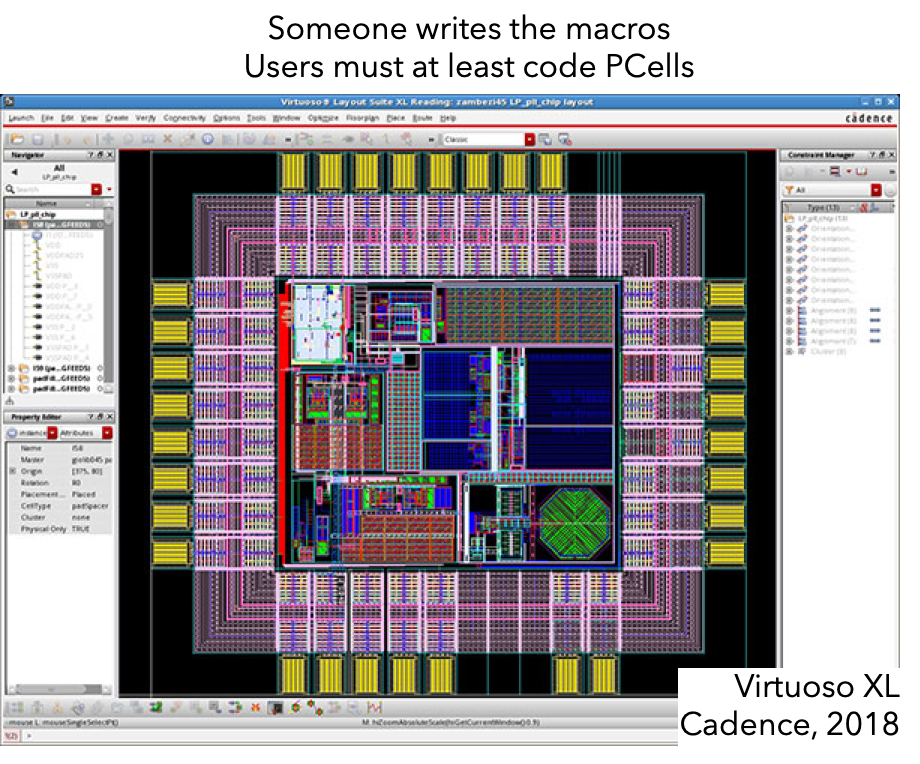

# Procedural IC design today


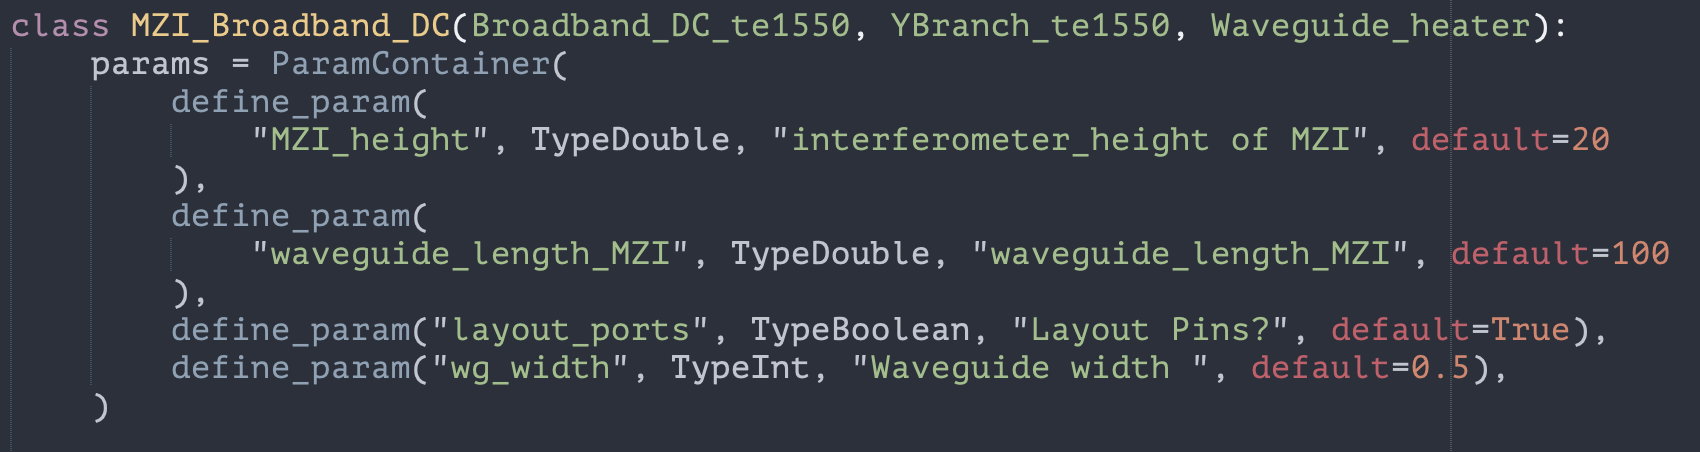

### What is new?

- Photonic integration
- High-level languages (Python)
- Free software infrastructure

### Difference with macros
- Procedural means 100% coded
- Push a button, GDS comes out
- This means entire chips are defined 100% by source code
    + repeatable
    + human understandable
    + arbitrarily complex
    + more easily version controlled

### Example from one of our chips

```python
# make_chip.py

FLOORPLAN_SAFE = 50
TECHNOLOGY = TECHNOLOGY.layers  # TODO refactor

if __name__ == "__main__":
    layout = pya.Layout()
    dbu = layout.dbu = 0.001
    TOP = layout.create_cell("TOP")

    origin = pya.DPoint(0, 0)
    ex = pya.DVector(1, 0)
    ey = rotate90(ex)

    # FLOORPLAN
    FX, FY = 7850, 3000  # um
    layout_box(TOP, layout.layer(TECHNOLOGY["FloorPlan"]), 
               origin, origin + FX * ex + FY * ey, ex)
    
    # Placing each experiment
    placement_list = {
        "FeedbackWeightBank_experiment": (
            exp.FeedbackWeightBank_experiment, # PCell class
            2792.04000, 328.87000,             # position
            {"angle_ex": 90, "N": 5},          # parameters
        ),
    # ...
    }
    
    # Place all PCells in placement_list and export port locations for routing
    for name, (klass, x, y, params) in placement_list.items():
        exp_ports[name] = klass(name, params=params).place_cell(
                TOP, x * ex + y * ey
            )
    # ...
    
    # Perform routing using exp_ports dictionary
    # ...
    
    # Removing the $$$CONTEXT_INFO$$$ top cell (Foundries don't like it)

    save_options = pya.SaveLayoutOptions()
    save_options.write_context_info = False
    
    # CMC told us to have maximum cell name length of 60 characters
    save_options.gds2_max_cellname_length = 60
    
    layout.write("mpw-chip.gds", save_options)
```

# Basic definitions

## PCells

PCells are the foundation of layouts with more than a couple polygons
- Rule of thumb: one pcell per device
- Defined by code (logic) instead of points (geometry)
- Reused to create many different geometries
- Easy to edit
- Can be nested

## Routing elements

Routing elements refer to the connections between devices (drawn in PCells). They could be metal traces, optical waveguides, or I/O elements.

## Ports

The connection between PCells and routing elements are defined in the concept of *Ports*. The port must contain information on the type of connection, the dimensions of the routing elemenet (e.g. waveguide width), a human-readable name, and positioning.

# Tool Requirements

- KLayout
- Python modules:
    + klayout
    + zeropdk

# KLayout

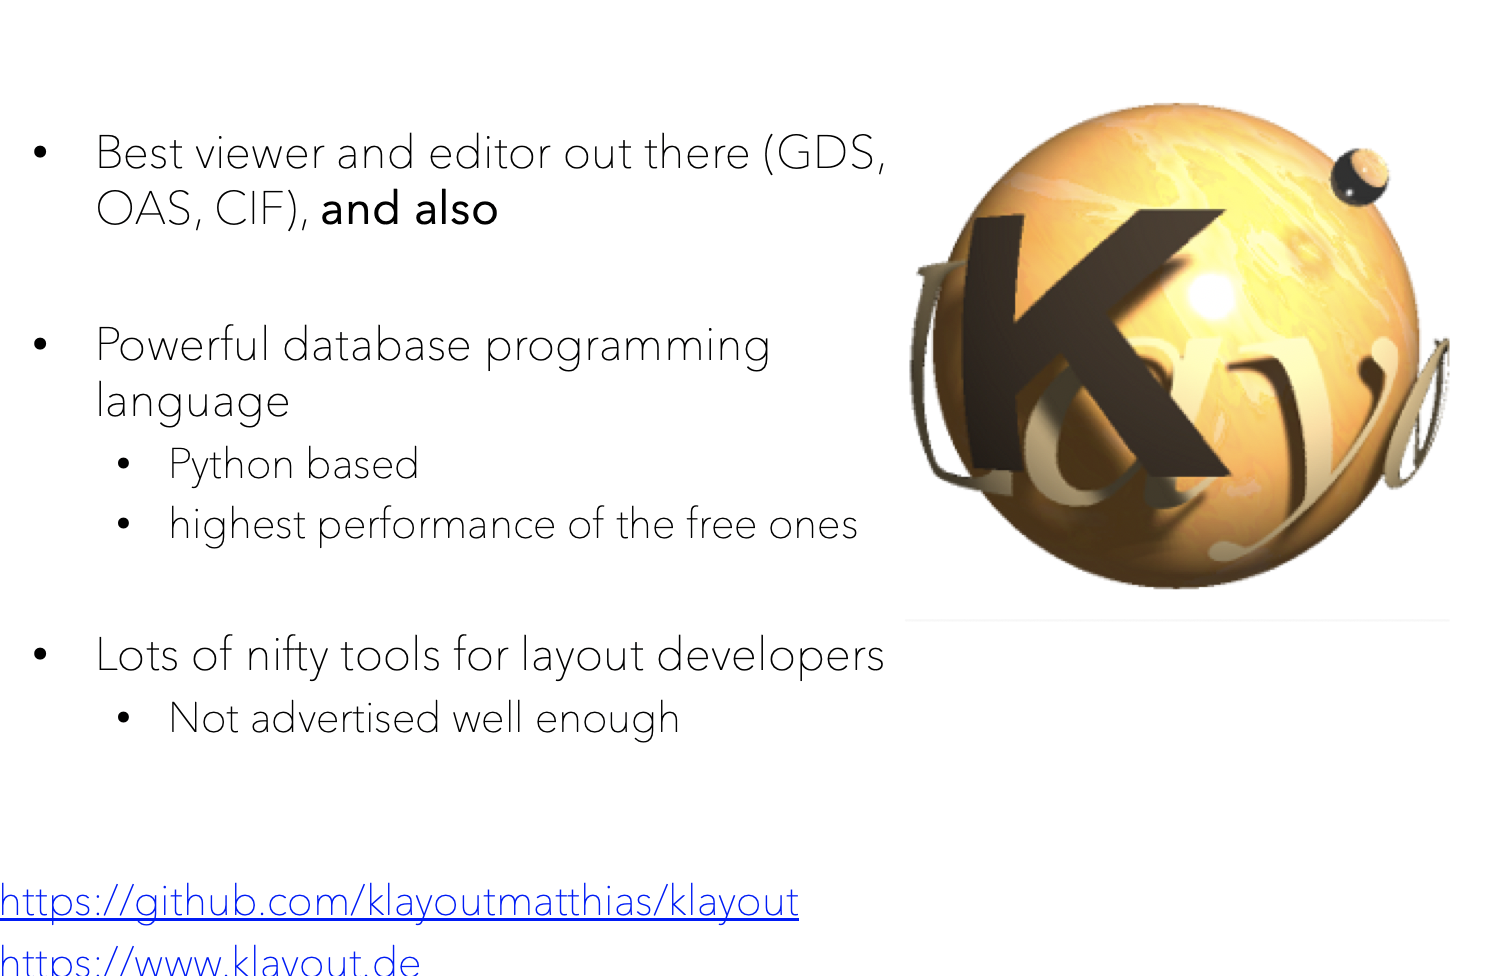

## KLayout scripting

You probably all know KLayout, but few people make good use of the scripting documentation:

- klayout.de » Documentation » **Programming Scripts** (recommend reading Database API and Geometry API)
- klayout.de » Documentation » **Reference** (have it open while coding)


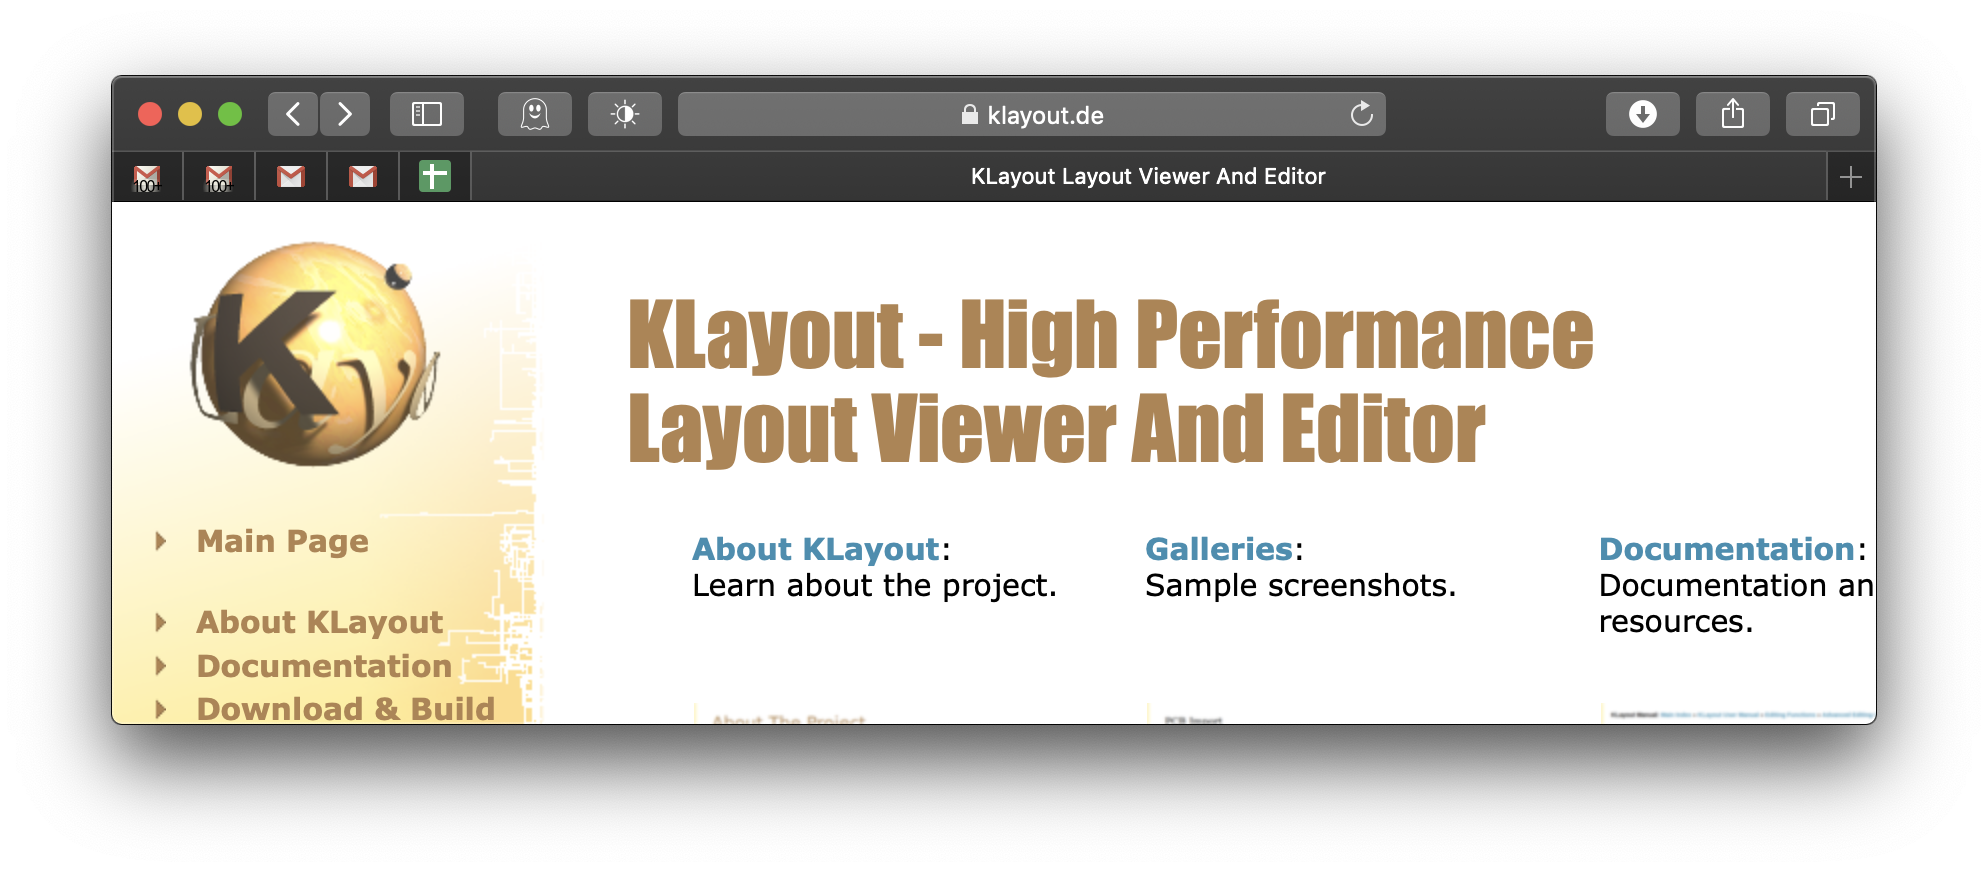

## Python (klayout)

I helped Matthias to release a klayout package in PyPI. It works in a standalone way and is loaded with the Database and Geometry APIs, but not Application or Qt (yet).

```bash
pip install klayout
```

Currently there are pre-built wheels in the following versions:

| OS | Python Version |
| --- | --- |
| macOS 10.11+ | 2.7, 3.7 |
| macOS 10.13+ | 3.5, 3.6 |
| linux x64, x32 | 2.7, 3.5, 3.6, 3.6 |
| win32, win64 | 3.5, 3.6, 3.7 |

*Note for advanced users:* You can attempt to build klayout from source by running `python setup.py install` on the cloned folder from [klayout's github repo](https://github.com/KLayout/klayout).



In [2]:
!pip install klayout

import klayout.db as pya

a = pya.DPoint(1, 2)
b = pya.DVector(0, 1)

a+b

1,3

## Python (zeropdk)

Our lab relies on klayout's database engine to produce masks for MPW manufacturing. To aid collaboration, we open-sourced a tool called zeropdk. 

Many foundries only offer PDKs to commercial software with a steep price tag, but are happy to offer libraries of standard components in the `.gds` format. *ZeroPDK* allows you to quickly bootstrap a Photonics PDK without necessarily relying on their partners: great for academic users and students. Also great for pro users.

Zeropdk is available with `pip install zeropdk` and the source code is released in our [github page](https://github.com/lightwave-lab/zeropdk)

# An overview of Zeropdk

- Three submodules:
    + `zeropdk.tech`: helps load a tech layer definition from a `lyp` file.
    + `zeropdk.layout`: a library of tools for advanced polygon creation (round polygons, waveguides, etc).
    + `zeropdk.pcell`: contains standard class definitions of PCells, ports and parameters. The idea is to make it compatible with SiEPIC-Tools and Klayout Macro Editor (eventually)
- Similarly to SiEPIC-Tools, *zeropdk* modifies/patches some Python bindings for klayout objects, such as SimplePolygon, Point, Vector.
- Beta status: scarce docs (need help!) 

In [1]:
!pip install zeropdk

In [4]:
!ls ../demo | grep .lyp

from zeropdk.tech import Tech
EBeam = Tech.load_from_xml('../demo/EBeam.lyp')
EBeam.layers

EBeam.lyp


{'Si': Si (1/0),
 '31_Si_p6nm': '31_Si_p6nm' (31/0),
 'Text': Text (10/0),
 'Si N': 'Si N' (20/0),
 'Si N++': 'Si N++' (24/0),
 'SEM': SEM (200/0),
 'M1': M1 (41/0),
 '12_M2': '12_M2' (12/0),
 '13_MLopen': '13_MLopen' (13/0),
 'VC': VC (40/0),
 'M Heater': 'M Heater' (47/0),
 'FloorPlan': FloorPlan (99/0),
 'DevRec': DevRec (68/0),
 'PinRec': PinRec (1/10),
 'FbrTgt': FbrTgt (81/0),
 'Errors': Errors (999/0),
 'Lumerical': Lumerical (733/0),
 'Waveguide': Waveguide (1/0)}

In [5]:
import zeropdk.layout.waveguide_rounding as wav_rounding

wav_rounding.main()  # produce some interesting non-Manhattan waveguides

Wrote waveguide_rounding.gds


In [7]:
# !open waveguide_rounding.gds

Contents of waveguide_rounding.gds:

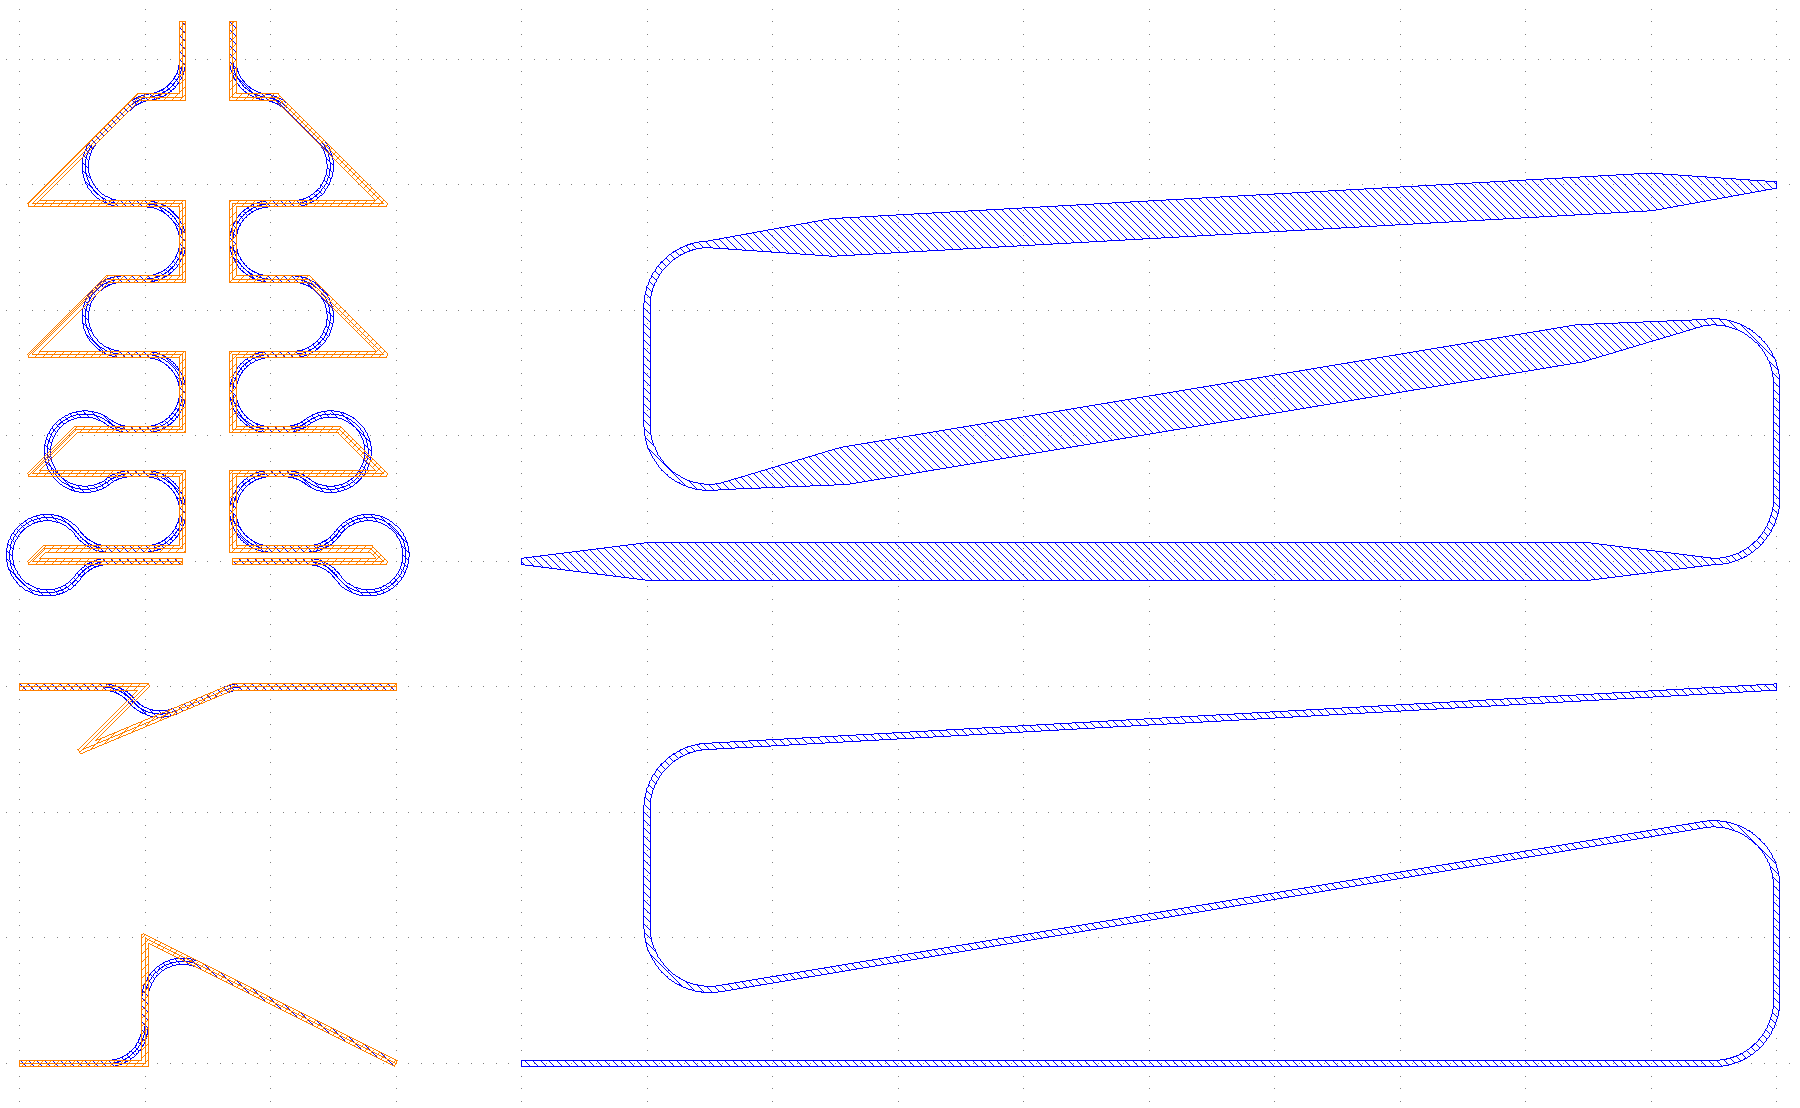

In [8]:
!python ../demo/main_python.py

Wrote to example_mask.gds


In [9]:
# !open example_mask.gds

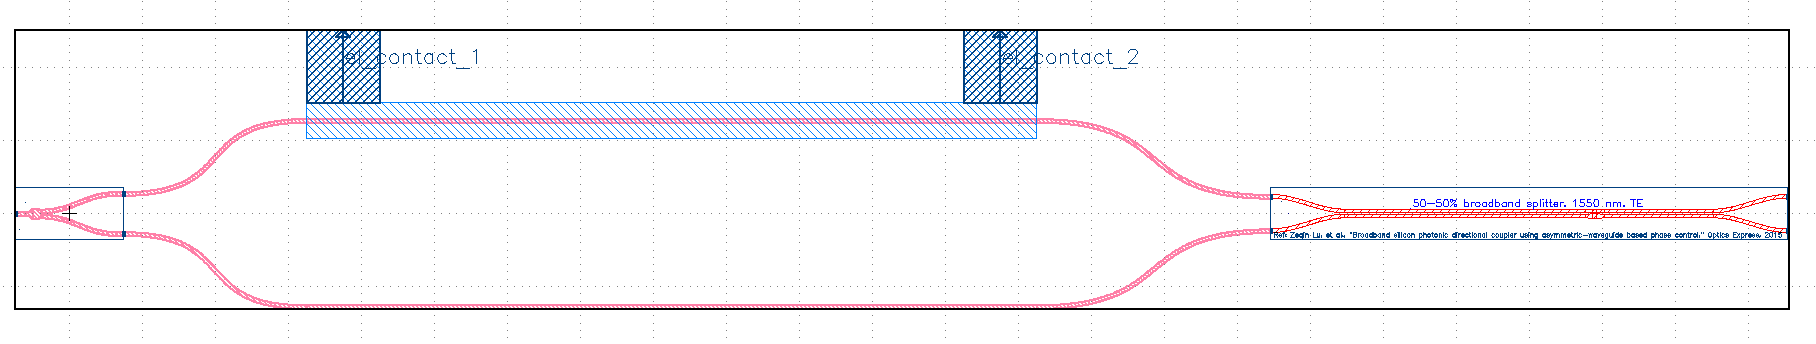

# Demo 1

Open `demo/1. Demo - Using SiEPIC cell library.ipynb`

# Demo 2

Open `demo/2. Demo - MZI PCell.ipynb`

# Advanced layout techniques

One goal: enable collaboration reduce dependence on a single designer or specific computer setup.

# Key questions – recommended tools

#### What is going on? – Visual debugging
- Python debugger + inter-process control (github.com/atait/klayout-ipc)

#### Is it working? – Geometric unit testing
- KLayout XOR diff program + Pytest (docs.pytest.org)

#### What if, oops, and collaborating – Version control
- Git (www.atlassian.com/git/tutorials)

#### What does this thing do? – Documentation & examples
- Sphinx (www.sphinx-doc.org)

#### What parts go where? – Modules, packaging
- Read and think about it (docs.python-guide.org/writing/structure)


## Procedural Layout introduces pitfalls
- Completely repeatable (but opaque and not interactive)
- Press a button, GDS comes out
- Easy to apply global changes (and introduce subtle side-effects)
- Easy to version and collaborate (and quietly break your friends’ stuff)
- Full record of design intent (or messy unreadable code)


Powerpoint presentation in person. Might share here later.